In [1]:
import json

#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import wfdb
from sklearn.preprocessing import Normalizer
from matplotlib import colors
from scipy.stats import norm
import random 

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [16]:
# extract only those RR from sample's rr where afib is happening, then calculate the RRI and concatenate
# them to generate a list of RRIs so that randomly RRIs can be picked to generate synthetic afib signals. 

def rr_intervals(rpeaks):
    """
    Calculates RR intervals. 

    Parameters
    ----------
    rpeaks : wfdb object
       wfdb annotation object with rpeaks from ecg signal

    Returns
    -------
    rr_intervals in seconds, rr_intervals in samples 
    """
    rr_samp = np.diff(rpeaks)
    rr_intervals_sec = samp2sec(rr_samp)
    return rr_samp, rr_intervals_sec

def samp2sec(x): 
    """
    Changes samples to seconds. 

    Parameters
    ----------
    sample : numpy array
        numpy array of single channel ecg from the wfdbdb-records

    Returns
    -------
    Sample changed into seconds
    """
    return (x / 250)  # Assuming a sampling rate of 250 Hz

def extract_afib_rr(use_samples):
    concatenated_RRIs = []
    all_RRIs = []
    
    for sample in use_samples:
        print(sample)
        qrs = wfdb.rdann(sample, 'qrs', pn_dir='afdb', summarize_labels=False)  # Reading annotation files for R-peak locations
        print(sample, ": ", qrs.sample)
        
        _, RRI = rr_intervals(qrs.sample)
        print(RRI)
        all_RRIs.append(RRI) 
        concatenated_RRIs.extend(RRI)
    return concatenated_RRIs, all_RRIs 

def pick_random_RRIs(all_RRIs, n_intervals=3000):
    # Check if the list contains at least n_intervals RRIs
    if len(all_RRIs) < n_intervals:
        raise ValueError("The list of RR intervals contains fewer than {} intervals.".format(n_intervals))
    
    # Randomly select n_intervals RRIs from the list
    random_RRIs = random.sample(all_RRIs, n_intervals)
    
    return random_RRIs

def add_variability(rr_intervals, variability_factor=0.05):
    """
    Add some random variability to the RR intervals to make synthetic signals more diverse.
    
    Parameters
    ----------
    rr_intervals : list of float
        Original RR intervals.
    variability_factor : float
        Factor determining the level of variability to add.
    
    Returns
    -------
    new_rr_intervals : list of float
        RR intervals with added variability.
    """
    new_rr_intervals = []
    for rr in rr_intervals:
        noise = np.random.normal(-0.2, variability_factor * rr)
        new_rr_intervals.append(rr + noise)
    return new_rr_intervals

# Main execution
concatenated_RRIs, all_RRIs = extract_afib_rr(['07162', '07859'])
RRIs = pick_random_RRIs(concatenated_RRIs)

# Add variability to the RR intervals to generate more diverse synthetic signals
synthetic_RRIs = add_variability(RRIs, variability_factor=0.05)
print(len(synthetic_RRIs))
print(len(all_RRIs[0]))

07162
07162 :  [    348     581     710 ... 9000167 9000394 9000619]
[0.932 0.516 1.172 ... 0.716 0.908 0.9  ]
07859
07859 :  [    139     276     423 ... 8996986 8997127 8997274]
[0.548 0.588 0.62  ... 0.564 0.564 0.588]
3000
39297


Real RR Mean: 0.9161280504873146, Real RR Std: 0.23472549826898315
Synthetic RR Mean: 0.5264064952487216, Synthetic RR Std: 0.2272810249342201


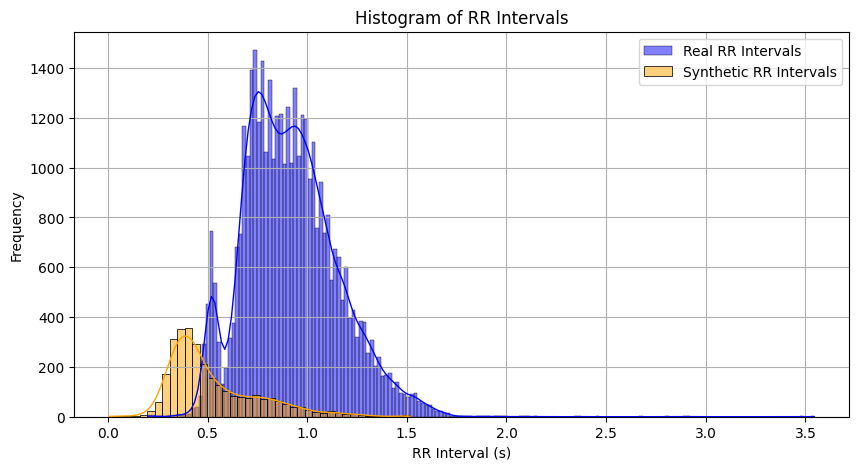

In [17]:
import seaborn as sns

def compare_rr_intervals(real_rr, synthetic_rr):
    real_rr = np.array(real_rr)
    synthetic_rr = np.array(synthetic_rr)
    
    # Statistical properties
    real_mean = np.mean(real_rr)
    real_std = np.std(real_rr)
    synthetic_mean = np.mean(synthetic_rr)
    synthetic_std = np.std(synthetic_rr)
    
    print(f"Real RR Mean: {real_mean}, Real RR Std: {real_std}")
    print(f"Synthetic RR Mean: {synthetic_mean}, Synthetic RR Std: {synthetic_std}")
    
    # Histogram
    plt.figure(figsize=(10, 5))
    
    sns.histplot(real_rr, color='blue', label='Real RR Intervals', kde=True)
    sns.histplot(synthetic_rr, color='orange', label='Synthetic RR Intervals', kde=True)
    
    plt.title('Histogram of RR Intervals')
    plt.xlabel('RR Interval (s)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage:
compare_rr_intervals(all_RRIs[0], synthetic_RRIs)

In [18]:
from syntmodel.synt_gen import model, generate_afib_randomset
from syntmodel.utils_model import Prms

# Function to load parameters from files
def load_params(param_files):
    params_list = []
    for file in param_files:
        with open(file, 'rb') as f:
            params = pickle.load(f)
        params_list.append(params)
    return params_list

# Function to generate datasets and return a pandas DataFrame
def generate_datasets_df(params_list, N, fs, sample_time, n_samples, synth_RR):
    data_records = []

    for _ in range(N):
        selected_params = np.random.choice(params_list)
        params = Prms(**selected_params)

        ecg_dataset, ecg_noise_set = generate_afib_randomset(params, fs, sample_time, n_samples, synth_RR)

        for data, noise_signal in zip(ecg_dataset, ecg_noise_set):

            ecg_signal, p_indices, q_indices, r_indices, s_indices, t_indices = data  # Unpacking the data correctly
            data_records.append({
                'ECG Signal': ecg_signal,
                'Noise Signal': noise_signal,
                'P Indices': p_indices,
                'Q Indices': q_indices,
                'R Indices': r_indices,
                'S Indices': s_indices,
                'T Indices': t_indices,
                'Params': selected_params
            })

    return pd.DataFrame(data_records)

In [19]:
#GENERATE 5000 AFIB ECG Signals of length:  10 seconds
# Step 1: Load and store parameters
param_files = [f"synth_params/afib_synth_beat_{i}.p" for i in range(22)]
params_list = load_params(param_files)
# Step 2 to 4: Generate datasets
# Generate datasets and organize into a DataFrame
N = 500  # Number of datasets to generate per random params (Total number of signals = N * n_samples) 
fs = 250  # Sample rate
sample_time = 10  # Seconds per sample
n_samples = 15  # Number of samples per dataset
random_RRI=random.sample(synthetic_RRIs,n_samples*2)
synth_RR=random_RRI
def generate_synth_afib_dataset(params_list, N, fs, sample_time, n_samples,synth_RR):
    
    afib_df = generate_datasets_df(params_list, N, fs, sample_time, n_samples,synth_RR)
    return afib_df
# Verify the shape of the DataFrame
afib_df =  generate_synth_afib_dataset(params_list, N, fs, sample_time, n_samples,synth_RR)
afib_df

,ECG Signal,Noise Signal,P Indices,Q Indices,R Indices,S Indices,T Indices,Params
0,"[1.2121460446302022e-07, 1.867398163362229e-09...","[0.025378700289144993, 0.022555098971812286, 0...","[114, 226, 310, 390, 483, 581, 703, 836, 968, ...","[16, 138, 250, 334, 414, 507, 605, 727, 860, 9...","[24, 146, 258, 342, 422, 514, 612, 734, 868, 1...","[34, 156, 268, 352, 432, 525, 623, 745, 878, 1...","[81, 203, 315, 399, 479, 572, 670, 792, 925, 1...","{'pa': 0.2, 'qa': -0.05, 'ra': -1.3, 'sa': 0.1..."
1,"[0.008132811685456234, 0.008133295375507766, 0...","[0.1492635616890575, 0.15008134315668548, -0.2...","[49, 161, 245, 325, 418, 516, 638, 771, 903, 1...","[82, 194, 278, 358, 451, 549, 671, 804, 936, 1...","[91, 203, 287, 367, 459, 557, 679, 813, 945, 1...","[103, 215, 299, 379, 472, 570, 692, 825, 957, ...","[31, 153, 265, 349, 429, 522, 620, 742, 875, 1...","{'pa': 0.2, 'qa': -0.05, 'ra': -1.3, 'sa': 0.1..."
2,"[0.17873562231949153, 0.11196535410250157, 0.0...","[-0.040167226414837796, -0.0691670142239952, -...","[46, 158, 242, 322, 415, 513, 635, 768, 900, 1...","[67, 179, 263, 343, 436, 534, 656, 789, 921, 1...","[75, 187, 271, 351, 443, 541, 663, 797, 929, 1...","[86, 198, 282, 362, 455, 553, 675, 808, 940, 1...","[7, 129, 241, 325, 405, 498, 596, 718, 851, 98...","{'pa': 0.2, 'qa': -0.05, 'ra': -1.3, 'sa': 0.1..."
3,"[0.011687445005569874, 0.010995717221474586, 0...","[0.05169641210269604, -0.09867350911014643, -0...","[94, 178, 258, 351, 449, 571, 704, 836, 984, 1...","[5, 117, 201, 281, 374, 472, 594, 727, 859, 10...","[13, 125, 209, 289, 381, 479, 601, 735, 867, 1...","[23, 135, 219, 299, 392, 490, 612, 745, 877, 1...","[74, 186, 270, 350, 443, 541, 663, 796, 928, 1...","{'pa': 0.2, 'qa': -0.05, 'ra': -1.3, 'sa': 0.1..."
4,"[-6.700385175387403e-17, -6.717980856502558e-1...","[-0.18201050170009572, -0.04476236703311249, -...","[110, 222, 306, 386, 479, 577, 699, 832, 964, ...","[18, 140, 252, 336, 416, 509, 607, 729, 862, 9...","[26, 148, 260, 344, 424, 516, 614, 736, 870, 1...","[37, 159, 271, 355, 435, 528, 626, 748, 881, 1...","[80, 202, 314, 398, 478, 571, 669, 791, 924, 1...","{'pa': 0.2, 'qa': -0.05, 'ra': -1.3, 'sa': 0.1..."
...,...,...,...,...,...,...,...,...
7495,"[0.0027848568059366096, 0.002642467961796195, ...","[-0.057593276110187976, 0.13006472235774028, 0...","[104, 188, 268, 361, 459, 581, 714, 846, 994, ...","[27, 139, 223, 303, 396, 494, 616, 749, 881, 1...","[37, 149, 233, 313, 406, 504, 626, 759, 891, 1...","[48, 160, 244, 324, 417, 515, 637, 770, 902, 1...","[95, 207, 291, 371, 464, 562, 684, 817, 949, 1...","{'pa': -0.2, 'qa': -0.5, 'ra': -3.4, 'sa': 0.8..."
7496,"[0.004441760041123143, 0.004441760041916717, 0...","[-0.02157253540764691, 0.04861170675648311, -0...","[51, 163, 247, 327, 420, 518, 640, 773, 905, 1...","[83, 195, 279, 359, 452, 550, 672, 805, 937, 1...","[93, 205, 289, 369, 462, 560, 682, 815, 947, 1...","[102, 214, 298, 378, 471, 569, 691, 824, 956, ...","[27, 149, 261, 345, 425, 518, 616, 738, 871, 1...","{'pa': -0.2, 'qa': -0.5, 'ra': -3.4, 'sa': 0.8..."
7497,"[0.018820508777649958, 0.031516830838418754, 0...","[0.12264337676223322, -0.18670258620034363, -0...","[39, 151, 235, 315, 408, 506, 628, 761, 893, 1...","[65, 177, 261, 341, 434, 532, 654, 787, 919, 1...","[74, 186, 270, 350, 443, 541, 663, 796, 928, 1...","[84, 196, 280, 360, 453, 551, 673, 806, 938, 1...","[12, 134, 246, 330, 410, 503, 601, 723, 856, 9...","{'pa': -0.2, 'qa': -0.5, 'ra': -3.4, 'sa': 0.8..."
7498,"[-0.04975908110307267, -0.017368464411224076, ...","[-0.15125506228158786, 0.3439617719177077, -0....","[79, 163, 243, 336, 434, 556, 689, 821, 969, 1...","[109, 193, 273, 366, 464, 586, 719, 851, 999, ...","[9, 121, 205, 285, 378, 476, 598, 731, 863, 10...","[19, 131, 215, 295, 388, 486, 608, 741, 873, 1...","[70, 182, 266, 346, 439, 537, 659, 792, 924, 1...","{'pa': -0.2, 'qa': -0.5, 'ra': -3.4, 'sa': 0.8..."


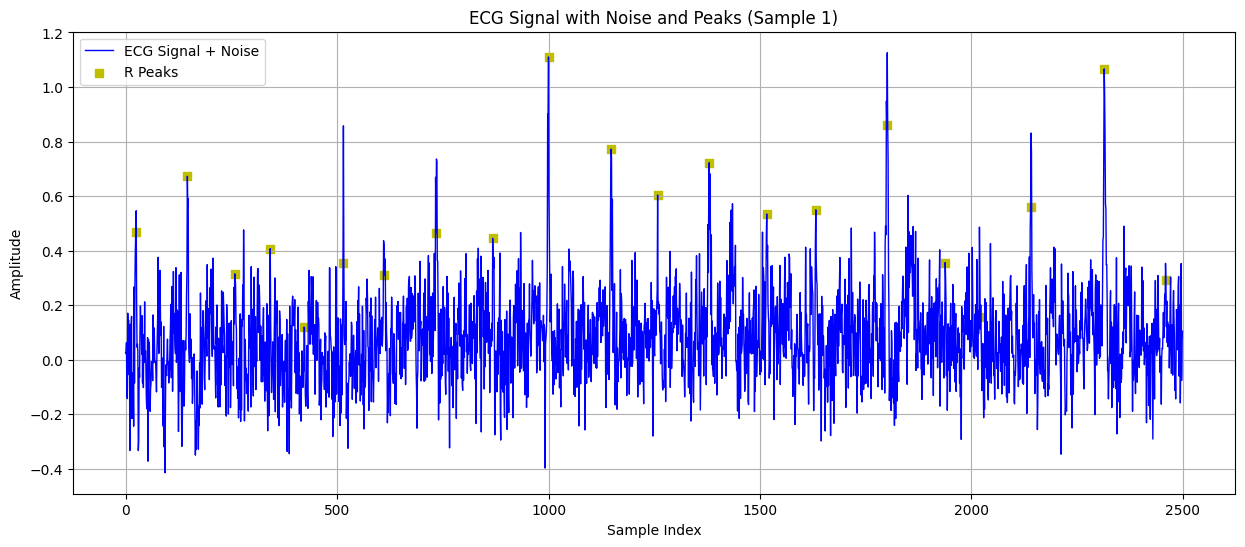

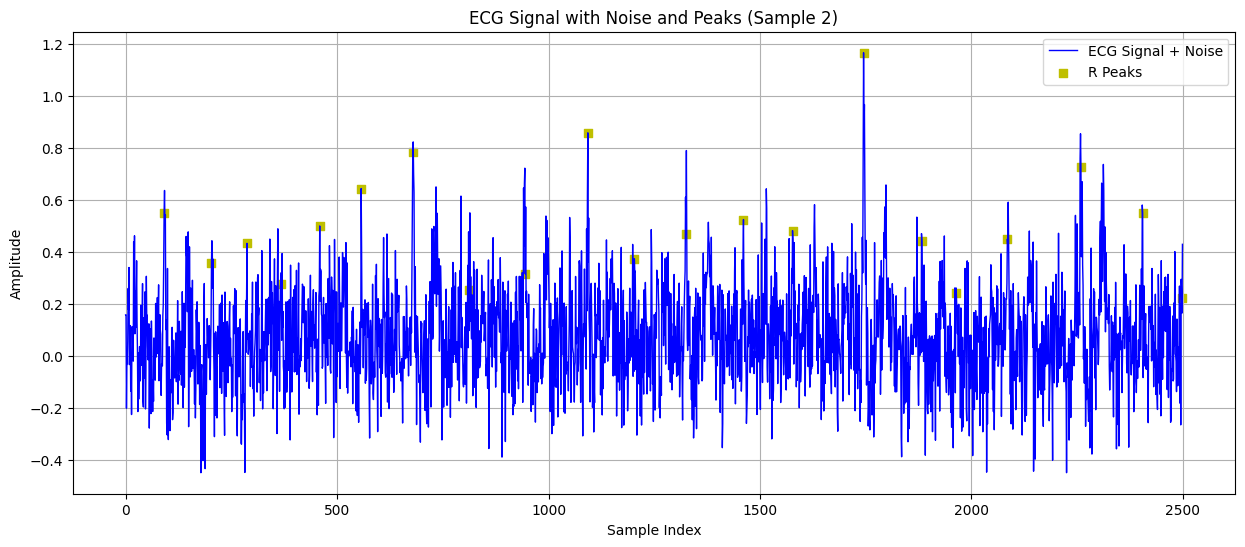

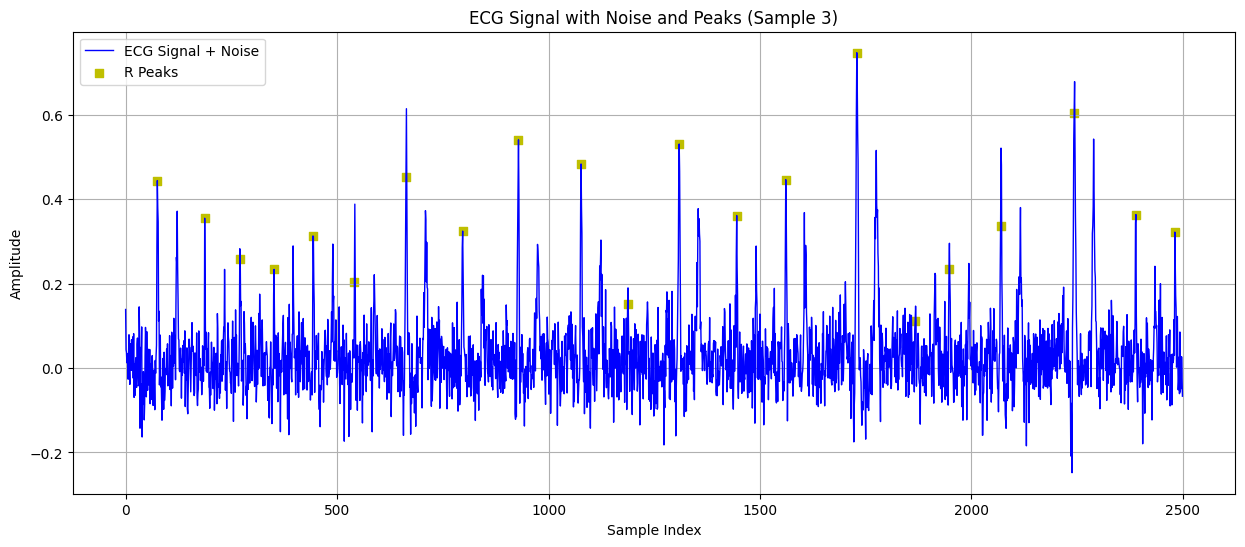

In [22]:
import matplotlib.pyplot as plt

# Function to plot ECG signals with noise and peak markers
def plot_ecg_signals_with_peaks(df, num_plots=1):
    for i in range(num_plots):
        ecg_signal = df.iloc[i]['ECG Signal']
        noise_signal = df.iloc[i]['Noise Signal']
        combined_signal = ecg_signal + noise_signal
        
        p_indices = df.iloc[i]['P Indices']
        q_indices = df.iloc[i]['Q Indices']
        r_indices = df.iloc[i]['R Indices']
        s_indices = df.iloc[i]['S Indices']
        t_indices = df.iloc[i]['T Indices']

        plt.plot(combined_signal, label='ECG Signal + Noise', color='b')
        
        #plt.scatter(p_indices, combined_signal[p_indices], color='r', label='P Peaks', marker='o')
        #plt.scatter(q_indices, combined_signal[q_indices], color='g', label='Q Peaks', marker='x')
        plt.scatter(r_indices, combined_signal[r_indices], color='y', label='R Peaks', marker='s')
        #plt.scatter(s_indices, combined_signal[s_indices], color='m', label='S Peaks', marker='d')
        #lt.scatter(t_indices, combined_signal[t_indices], color='c', label='T Peaks', marker='^')
        
        plt.title(f'ECG Signal with Noise and Peaks (Sample {i+1})')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
# Plot the first 5 ECG signals in the DataFrame
plot_ecg_signals_with_peaks(afib_df, num_plots=3)

In [21]:
afib_df.to_pickle('afib_dataset.pkl')
